In [15]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt



%matplotlib inline

In [16]:
#!pip install --upgrade google-cloud-bigquery

In [17]:
from google.cloud import bigquery


In [18]:

from google.oauth2 import service_account


### Run simple single series examples with 
* Simple Exponential smoothing (select alpha automaticall)
* Holts Winters
* Holts Winters Seasonally Adjusted

In [ ]:

# credentials = service_account.Credentials.from_service_account_file(
# 'big_query.json')

# project_id = 'u4cast-cr'
# client = bigquery.Client(credentials= credentials,project=project_id)
# query = """SELECT * FROM `u4cast-cr.finance_data.historical_sales` """
# query_job = client.query(query)  # Make an API request.

# q_results =query_job.result()
# df = q_results.to_dataframe()

### Data 
Data will be from IOWA liquor sales.<br>
https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy

**Transformation**: aggregated total sales by store by week from 2018 to 2022. Pick top 100 stores by sales for this period.



**Load Data**

In [27]:
df = pd.read_csv('iowa_liquors.csv')

In [28]:
df.head()

,date,store_number,store_name,city,county,sales
0,2022-01-09,4129,Cyclone Liquors,Ames,STORY,3570.58
1,2022-01-16,4129,Cyclone Liquors,Ames,STORY,13461.98
2,2022-01-23,4129,Cyclone Liquors,Ames,STORY,12398.75
3,2022-01-30,4129,Cyclone Liquors,Ames,STORY,15761.38
4,2022-02-06,4129,Cyclone Liquors,Ames,STORY,14926.81


In [30]:
df.date = pd.to_datetime(df.date)
df.dtypes

date            datetime64[ns]
store_number             int64
store_name              object
city                    object
county                  object
sales                  float64
dtype: object

In [31]:
df.store_number.unique()

array([4129, 2501, 3524, 2500, 2505, 2642, 5144, 2502, 2666, 2191, 2555,
       2560, 2517, 2665, 2548, 2593, 2616, 2595, 2624, 2649, 3944, 2524,
       3390, 5257, 2543, 2565, 2651, 2591, 2587, 2130, 3494, 2571, 2538,
       2643, 2635, 2637, 3354, 2625, 2614, 2549, 2285, 2622, 2513, 2512,
       2573, 2662, 2663, 3952, 2603, 2506, 4969, 2670, 4677, 4829, 2673,
       2190, 2633, 2561, 2528, 2527, 2636, 2626, 2644, 2539, 2582, 2515,
       5351, 3820, 3447, 2594, 2621, 2623, 2576, 4988, 2106, 2572, 2522,
       3773, 2647, 3385, 2605, 2508, 2552, 2590, 2588, 2544, 5102, 2536,
       4312, 3477, 2613, 2629, 2558, 2648, 2535, 3814, 2619, 2521, 2620,
       3420], dtype=int64)

### Test a single series
**Pop off just one sereies**

In [32]:
sdf = df[(df['store_number'] ==3814)]

In [36]:
#sdf.shape
sdf.sort_values(by='date',inplace=True)
#sdf.tail()

c:\Users\olive\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [39]:
sdf = sdf[['date','sales']]

In [40]:
sdf.dtypes

date     datetime64[ns]
sales           float64
dtype: object

#### Processing 
1. Sort Data
2. Select Forecast Horizon (h)
3. Create the date range of size h

In [41]:
sdf.set_index('date',inplace=True)

In [57]:
sdf.head()

,sales
date,
2018-01-07,14731.32
2018-01-14,53861.64
2018-01-28,9003.60
2018-02-04,13147.20
2018-02-11,162925.92


In [64]:
# select forecast horizon 
h = 26

In [63]:
sdf.index.max()

Timestamp('2022-02-06 00:00:00')

In [74]:
# inclusive parameter not working. Using a list indexing to exclude start
fc_index = pd.date_range(start=sdf.index.max(), periods=h+1, freq="W")[1:]

In [75]:
len(fc_index)

26

In [76]:
fit1 = ExponentialSmoothing(sdf,
    seasonal_periods = 52,
    trend='add',seasonal='add',
    use_boxcox=True,
    initialization_method='estimated',).fit()

c:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<AxesSubplot:xlabel='date'>

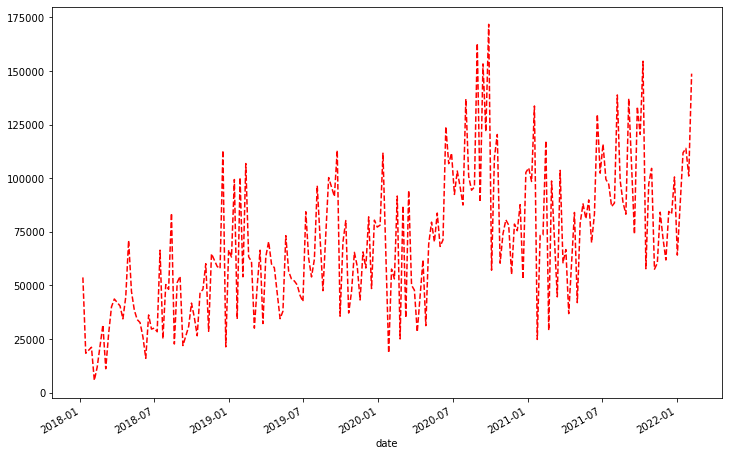

In [77]:
#type(fit1.fittedvalues)
#fit1.fittedvalues.plot()

fig, ax = plt.subplots(figsize=(12,8))
fit1.fittedvalues.plot(ax=ax, style="--", color="red")

In [191]:
hist_df = pd.DataFrame(fit1.fittedvalues,index=sdf.index)

In [192]:
hist_df.columns = ['sales']

In [193]:
hist_df = hist_df.reset_index()
hist_df.head()

,date,sales
0,2018-01-07,53708.455430
1,2018-01-14,18328.606463
2,2018-01-28,21120.727406
3,2018-02-04,5667.002336
4,2018-02-11,11828.032375


In [187]:
fit1.forecast(h)

c:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


201     28666.416056
202     78262.752193
203     72085.205187
204    105136.420676
205     36637.898759
206    101567.333224
207     51355.036079
208    111754.136965
209     60460.581556
210     60974.457554
211     31173.927446
212     46587.178618
213     68942.959876
214     34494.262060
215     65559.360306
216     76353.389026
217     72903.724943
218     72758.763440
219     53332.493043
220     59216.976012
221    101136.160404
222     82310.438997
223     72688.638123
224     66576.765990
225     67096.891993
226     61792.250578
dtype: float64

In [189]:
fc_index


DatetimeIndex(['2022-02-13', '2022-02-20', '2022-02-27', '2022-03-06',
               '2022-03-13', '2022-03-20', '2022-03-27', '2022-04-03',
               '2022-04-10', '2022-04-17', '2022-04-24', '2022-05-01',
               '2022-05-08', '2022-05-15', '2022-05-22', '2022-05-29',
               '2022-06-05', '2022-06-12', '2022-06-19', '2022-06-26',
               '2022-07-03', '2022-07-10', '2022-07-17', '2022-07-24',
               '2022-07-31', '2022-08-07'],
              dtype='datetime64[ns]', freq='W-SUN')

In [185]:
fc_df = pd.DataFrame(fit1.forecast(h),index=fc_index)


c:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [186]:
fc_df.head()

,0
2022-02-13,NaN
2022-02-20,NaN
2022-02-27,NaN
2022-03-06,NaN
2022-03-13,NaN


In [148]:
#fc_df.shape
fc_df = fc_df.reset_index()


,index,0
0,201,28666.416056
1,202,78262.752193
2,203,72085.205187
3,204,105136.420676
4,205,36637.898759


In [151]:
fc_df['date'] = fc_index

In [154]:
fc_df = fc_df[['date',0]]

In [85]:
fc_df = fc_df.set_index(fc_index)
# = fc_index

In [156]:
fc_df.columns = ['date','forecast']
fc_df.head()

,date,forecast
0,2022-02-13,28666.416056
1,2022-02-20,78262.752193
2,2022-02-27,72085.205187
3,2022-03-06,105136.420676
4,2022-03-13,36637.898759


In [161]:
temp_df = hist_df.tail(1)
temp_df.columns = ['forecast']

In [162]:
temp_df.reset_index(inplace=True)
temp_df

,date,forecast
0,2022-02-06,148779.899523


In [172]:
new_fc_df = pd.concat([temp_df,fc_df])
# new_fc_df.reset_index(inplace=True)
# new_fc_df.drop(['index'],axis=1)
new_fc_df.head()

,date,forecast
0,2022-02-06,148779.899523
0,2022-02-13,28666.416056
1,2022-02-20,78262.752193
2,2022-02-27,72085.205187
3,2022-03-06,105136.420676


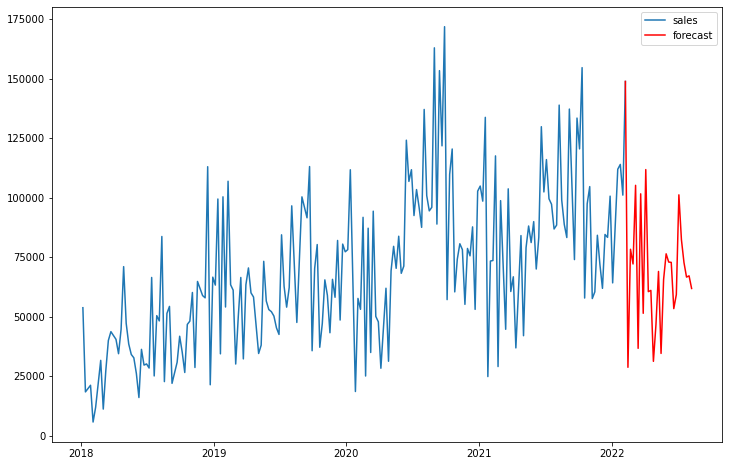

In [202]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hist_df.date,hist_df.sales,label='sales')
ax.plot(new_fc_df.date,new_fc_df.forecast,color='red',label='forecast')
ax.legend()
#plt.plot(x=new_fc_df.date,y=new_fc_df.forecast, style="--",color="red",legend=True)